In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('Bank Customer Churn Prediction.csv')
df.drop('customer_id', axis=1, inplace=True)

X = df.drop('churn', axis=1)
y = df['churn']

# Divide data into training and validation subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44, stratify=y)

df_train = X_train.join(y_train)    # 80% train set
df_test = X_test.join(y_test)       # 20% test set

In [4]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder

categorical_cols = ['country', 'gender', 'credit_card', 'active_member']
numerical_cols = ['credit_score',
                  'age',
                  'tenure',
                  'balance',
                  'products_number',
                  'estimated_salary']

preprocess = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('cat', OrdinalEncoder(), categorical_cols)
    ]
)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, TomekLinks, ClusterCentroids, RepeatedEditedNearestNeighbours, EditedNearestNeighbours, AllKNN

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFpr, chi2
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    XGBClassifier()
]

over_samplers = SMOTE(sampling_strategy=0.75, k_neighbors=3)
under_samplers = [
    NearMiss(version=3, n_neighbors_ver3=3),
    TomekLinks(),
    ClusterCentroids(voting='hard'),
    RepeatedEditedNearestNeighbours(),
    EditedNearestNeighbours(),
    AllKNN()
]

reports = []
for model in models:
    for under_sampler in under_samplers:
        pipeline = Pipeline(steps=[
            ('preprocess', preprocess),
            ('over_sampler', over_samplers),
            ('under_sampler', under_sampler),
            ('selectior', SelectFpr(score_func=chi2, alpha=0.1)),
            ('reducer', StandardScaler()),
            (type(model).__name__, model)
        ], verbose=True)

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        reports.append((pipeline, '{}-{}'.format(type(model).__name__, type(under_sampler).__name__), classification_report(y_test, y_pred, output_dict=True), y_pred))

In [7]:
df_eval = pd.DataFrame([[x[1], *[x[2]['0'][y] for y in x[2]['0']][:-1], *[x[2]['1'][y] for y in x[2]['0']][:-1], x[2]['weighted avg']['f1-score'], x[2]['accuracy']] for x in reports],
             columns=['Method', 'Class 0: Precision', 'Class 0: Recall', 'Class 0: F1-Score', 'Class 1: Precision', 'Class 1: Recall', 'Class 1: F1-Score', 'Weighted F1-Score', 'Accuracy Score']).round(2)
df_eval.sort_values(by=['Class 1: F1-Score'], ascending=False).reset_index(drop=True)

,Method,Class 0: Precision,Class 0: Recall,Class 0: F1-Score,Class 1: Precision,Class 1: Recall,Class 1: F1-Score,Weighted F1-Score,Accuracy Score
0,XGBClassifier-TomekLinks,0.90,0.92,0.91,0.64,0.58,0.61,0.85,0.85
1,SVC-TomekLinks,0.91,0.87,0.89,0.55,0.65,0.60,0.83,0.82
2,XGBClassifier-AllKNN,0.92,0.82,0.87,0.51,0.72,0.60,0.81,0.80
3,XGBClassifier-EditedNearestNeighbours,0.92,0.81,0.86,0.50,0.73,0.59,0.81,0.79
4,RandomForestClassifier-TomekLinks,0.89,0.89,0.89,0.58,0.57,0.58,0.83,0.83
5,XGBClassifier-RepeatedEditedNearestNeighbours,0.92,0.80,0.86,0.48,0.73,0.58,0.80,0.79
6,RandomForestClassifier-AllKNN,0.92,0.81,0.86,0.49,0.72,0.58,0.80,0.79
7,SVC-ClusterCentroids,0.91,0.82,0.86,0.49,0.69,0.57,0.80,0.79
8,RandomForestClassifier-RepeatedEditedNearestNe...,0.92,0.78,0.84,0.46,0.73,0.57,0.79,0.77
9,DecisionTreeClassifier-RepeatedEditedNearestNe...,0.92,0.78,0.84,0.45,0.72,0.56,0.78,0.77


In [8]:
query = ['Class 1: F1-Score']
df_eval['Model'] = df_eval['Method'].str.split('-').str[0]

sorted_df = df_eval.groupby('Model').apply(lambda x: x.sort_values(by=query, ascending=False), include_groups=False)
results = sorted_df.iloc[::7].reset_index(level=0).index

sorted_df.iloc[::7].reset_index(level=0)[['Method', 'Class 1: Precision', 'Class 1: Recall', 'Weighted F1-Score', 'Accuracy Score']]

,Method,Class 1: Precision,Class 1: Recall,Weighted F1-Score,Accuracy Score
3,DecisionTreeClassifier-RepeatedEditedNearestNe...,0.45,0.72,0.78,0.77
11,RandomForestClassifier-AllKNN,0.49,0.72,0.80,0.79
16,SVC-EditedNearestNeighbours,0.41,0.79,0.75,0.72
21,XGBClassifier-RepeatedEditedNearestNeighbours,0.48,0.73,0.80,0.79


# Top 1 method on each model.

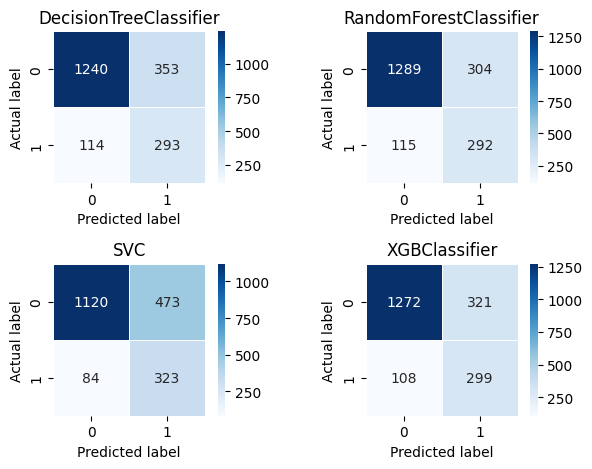

In [9]:
from sklearn.metrics import confusion_matrix

top_n = [(reports[x][1], reports[x][3]) for x in results]

half = len(top_n) // 2
fig, axs = plt.subplots(nrows=(half * 2 // half), ncols=half) #, figsize=(15, 10))
axs = axs.flat

for i, j in enumerate(top_n):
    cm = confusion_matrix(y_test, j[1])
    sns.heatmap(data=cm, linewidths=.5, annot=True, square=True, cmap='Blues', fmt='.0f', ax=axs[i])
    axs[i].set_ylabel('Actual label')
    axs[i].set_xlabel('Predicted label')
    axs[i].set_title('{}'.format(j[0].split('-')[0]))
    
plt.tight_layout()
plt.show()

# Grid Search

In [13]:
from sklearn.model_selection import GridSearchCV

param_grids = {
    'DecisionTreeClassifier': {
        'DecisionTreeClassifier__max_depth': [2, 3, 5, 10, 20],
        'DecisionTreeClassifier__min_samples_leaf': [5, 10, 20, 50, 100],
        'DecisionTreeClassifier__criterion': ["gini", "entropy"]
    },
    'RandomForestClassifier': { 
        'RandomForestClassifier__n_estimators': [25, 50, 100, 150], 
        'RandomForestClassifier__max_features': ['sqrt', 'log2', None], 
        'RandomForestClassifier__max_depth': [3, 6, 9], 
        'RandomForestClassifier__max_leaf_nodes': [3, 6, 9], 
    },
    'SVC': {
        'SVC__C': [0.1, 1, 10, 100, 1000],  
        'SVC__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
        'SVC__kernel': ['rbf']
    },
    'XGBClassifier': {
        'XGBClassifier__min_child_weight': [1, 5, 10],
        'XGBClassifier__gamma': [0.5, 1, 1.5, 2, 5],
        'XGBClassifier__subsample': [0.6, 0.8, 1.0],
        'XGBClassifier__colsample_bytree': [0.6, 0.8, 1.0],
        'XGBClassifier__max_depth': [3, 4, 5]
    }
}

# search = GridSearchCV(pipe, param_grid, cv=5).fit(X, y)
top_n = [(x, reports[x][1].split('-')[0], reports[x][0]) for x in results]
searched = []
for i, j in enumerate(top_n):
    search = GridSearchCV(j[2], param_grids[j[1]], cv=5, refit='').fit(X_train, y_train)
    searched.append(search)

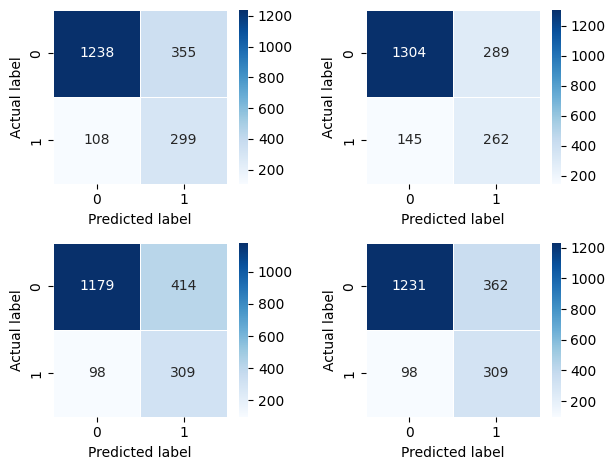

In [15]:
from sklearn.metrics import confusion_matrix

top_n = searched

half = len(top_n) // 2
fig, axs = plt.subplots(nrows=(half * 2 // half), ncols=half) #, figsize=(15, 10))
axs = axs.flat

for i, j in enumerate(top_n):
    cm = confusion_matrix(y_test, j.predict(X_test))
    sns.heatmap(data=cm, linewidths=.5, annot=True, square=True, cmap='Blues', fmt='.0f', ax=axs[i])
    axs[i].set_ylabel('Actual label')
    axs[i].set_xlabel('Predicted label')
    # axs[i].set_title('{}'.format(j[0].split('-')[0]))
    
plt.tight_layout()
plt.show()